In [10]:
path = './DATASET/hour.csv'

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [52]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi': 80})

In [12]:
# pip install tensorflow

In [13]:
# pip install keras

In [14]:
# pip install pmdarima

# Loading dataset

In [15]:
data = pd.read_csv(path)
def get_data():
    return data

In [16]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [17]:
data['time'] = pd.to_datetime(data['dteday']) + pd.to_timedelta(data['hr'], unit='h')
data['time'] = data['time'].dt.strftime('%m-%d-%Y %H:%M:%S')

In [9]:
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,01-01-2011 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,01-01-2011 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,01-01-2011 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,01-01-2011 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,01-01-2011 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,12-31-2012 19:00:00
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,12-31-2012 20:00:00
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,12-31-2012 21:00:00
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,12-31-2012 22:00:00


In [10]:
categorical_features = ['season', 'holiday', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit']
numerical_features = ['temp', 'hum', 'windspeed']
features = categorical_features + numerical_features
target = ['cnt']

In [11]:
data[numerical_features].describe()

,temp,hum,windspeed
count,17379.000000,17379.000000,17379.000000
mean,0.496987,0.627229,0.190098
std,0.192556,0.192930,0.122340
min,0.020000,0.000000,0.000000
25%,0.340000,0.480000,0.104500
50%,0.500000,0.630000,0.194000
75%,0.660000,0.780000,0.253700
max,1.000000,1.000000,0.850700


In [12]:
data.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
time          False
dtype: bool

# Splitting data into train and test

In [13]:
train, test = train_test_split(data, random_state=42, shuffle=True)

In [14]:
train

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
1945,1946,2011-03-26,2,0,3,20,0,6,0,2,0.28,0.2727,0.45,0.2537,18,67,85,03-26-2011 20:00:00
13426,13427,2012-07-18,3,1,7,15,0,3,1,3,0.92,0.8485,0.35,0.3582,42,152,194,07-18-2012 15:00:00
12898,12899,2012-06-26,3,1,6,15,0,2,1,1,0.72,0.6515,0.28,0.4627,88,229,317,06-26-2012 15:00:00
2570,2571,2011-04-22,2,0,4,0,0,5,1,1,0.36,0.3485,0.62,0.1940,3,30,33,04-22-2011 00:00:00
10764,10765,2012-03-29,2,1,3,15,0,4,1,1,0.52,0.5000,0.39,0.3582,109,198,307,03-29-2012 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,11285,2012-04-20,2,1,4,9,0,5,1,1,0.46,0.4545,0.88,0.0896,30,329,359,04-20-2012 09:00:00
11964,11965,2012-05-18,2,1,5,17,0,5,1,1,0.66,0.6212,0.34,0.1343,124,688,812,05-18-2012 17:00:00
5390,5391,2011-08-17,3,0,8,12,0,3,1,1,0.80,0.7273,0.43,0.2836,26,163,189,08-17-2011 12:00:00
860,861,2011-02-08,1,0,2,7,0,2,1,1,0.24,0.1970,0.65,0.4179,3,97,100,02-08-2011 07:00:00


In [15]:
print("Min Temp value: ", data['temp'].min())
print("Max Temp value: ", data['temp'].max())

Min Temp value:  0.02
Max Temp value:  1.0


# Outlier analysis

[Text(0.5, 0, 'Temperature'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

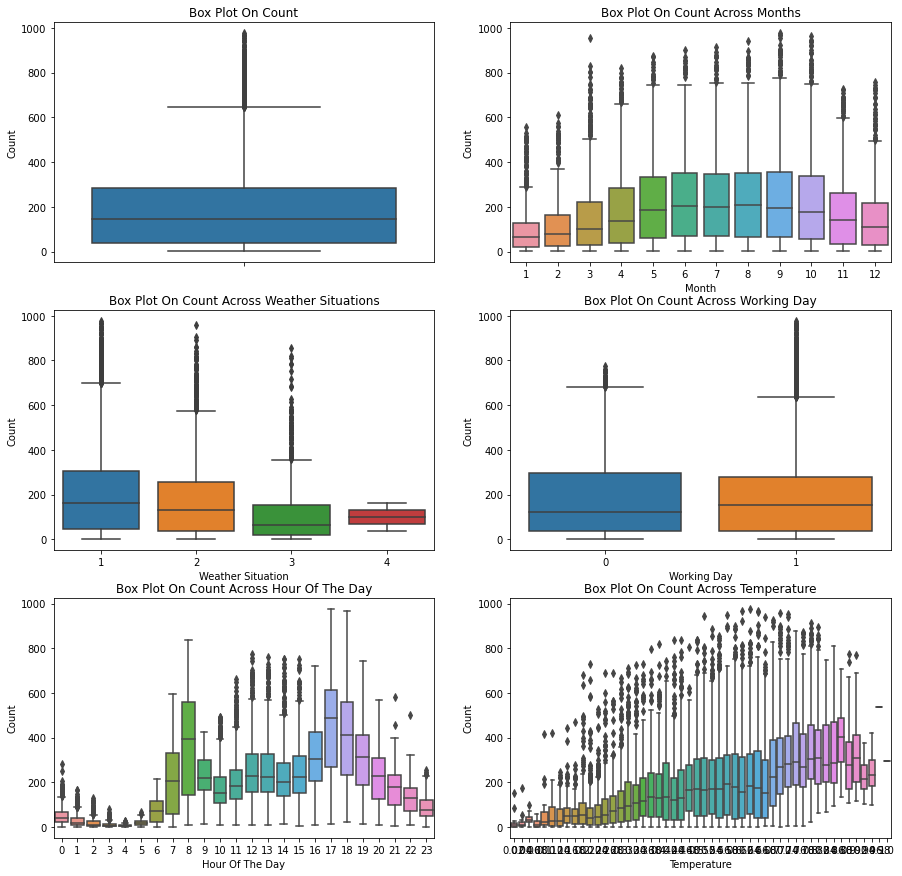

In [16]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=train,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="cnt",x="hr",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="cnt",x="temp",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")

# Removing outliers

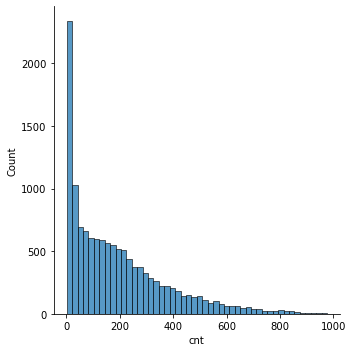

In [17]:
sns.displot(train['cnt'])

In [18]:
print("Total data: ",train.cnt.count())

Total data:  13034


In [19]:
# q1 = train.cnt.quantile(0.25)
# q3 = train.cnt.quantile(0.75)
# iqr = q3 - q1
# lower_bound = q1 -(1.5 * iqr) 
# upper_bound = q3 +(1.5 * iqr)
# outliers = train.loc[(train.cnt < lower_bound) | (train.cnt > upper_bound)]
# train = train.loc[(train.cnt >= lower_bound) & (train.cnt <= upper_bound)]

In [20]:
# outliers.cnt

In [21]:
# correct.cnt

In [22]:
# print("Total data: ",train.cnt.count())

<AxesSubplot:>

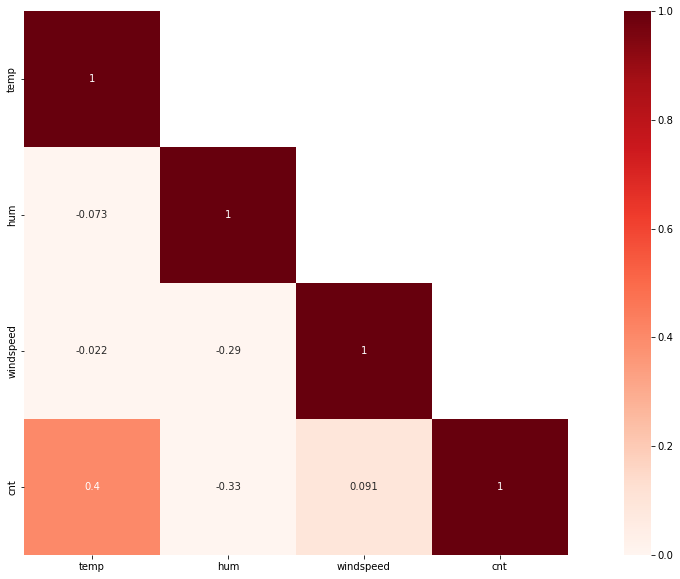

In [23]:
matrix = train[numerical_features  + target].corr()
heat = np.array(matrix)

heat[np.tril_indices_from(heat)] = False
fig, axs = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(matrix,mask=heat, vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

<AxesSubplot:>

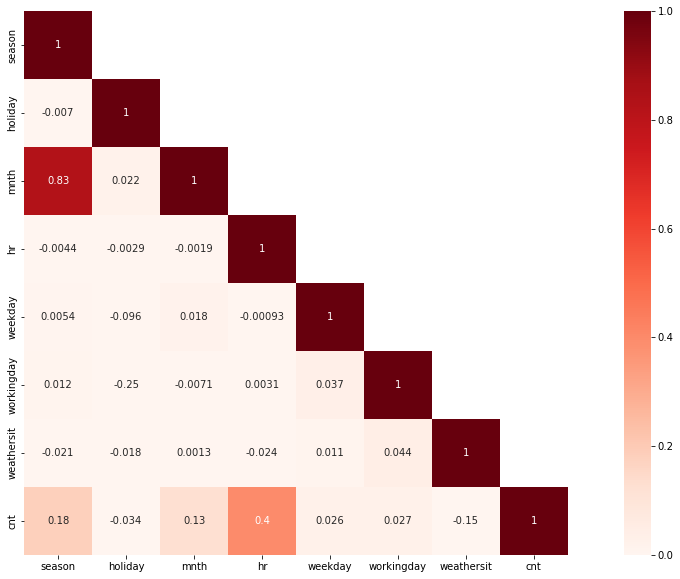

In [24]:
matrix = train[categorical_features  + target].corr()
heat = np.array(matrix)

heat[np.tril_indices_from(heat)] = False
fig, axs = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(matrix,mask=heat, vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

In [25]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time
1945,1946,2011-03-26,2,0,3,20,0,6,0,2,0.28,0.2727,0.45,0.2537,18,67,85,03-26-2011 20:00:00
13426,13427,2012-07-18,3,1,7,15,0,3,1,3,0.92,0.8485,0.35,0.3582,42,152,194,07-18-2012 15:00:00
12898,12899,2012-06-26,3,1,6,15,0,2,1,1,0.72,0.6515,0.28,0.4627,88,229,317,06-26-2012 15:00:00
2570,2571,2011-04-22,2,0,4,0,0,5,1,1,0.36,0.3485,0.62,0.1940,3,30,33,04-22-2011 00:00:00
10764,10765,2012-03-29,2,1,3,15,0,4,1,1,0.52,0.5000,0.39,0.3582,109,198,307,03-29-2012 15:00:00


In [26]:
x_train = train[features].values
y_train = train[target].values.ravel()

forest = RandomForestRegressor(n_estimators=200, random_state=1)
forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=1)

In [27]:
print("For train data: ")
pred = forest.predict(x_train)

mse = mean_squared_error(y_train, pred)
score = forest.score(x_train, y_train)
rmsle = np.sqrt(mean_squared_log_error(y_train, pred))
mae = mean_absolute_error(y_train, pred)

print("MSE: ", mse)
print("R square score: ", score)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

For train data: 
MSE:  623.5923368285158
R square score:  0.98118497241367
RMSLE:  0.18412022537455838
MAE:  16.249739377598516


In [28]:
print("For Test data: ")

x_test = test[features].values
y_test = test[target].values.ravel()

pred = forest.predict(x_test)

mse = mean_squared_error(y_test, pred)
score = forest.score(x_test, y_test)
rmsle = np.sqrt(mean_squared_log_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("MSE: ", mse)
print("R square score: ", score)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

For Test data: 
MSE:  4319.533020910866
R square score:  0.8656791103742052
RMSLE:  0.4144241722226815
MAE:  42.76768902131624


# ARMA Model

In [29]:
dup_df = data.copy()

split = int(len(dup_df) * 0.8)

dup_df.set_index(keys=['time'], inplace=True)

dup_df.index = pd.to_datetime(dup_df.index)

In [30]:
train_data = dup_df.iloc[:split]
test_data = dup_df.iloc[split:]

In [31]:
print("Length before resampling: ", str(len(train_data)))
new_train_data = train_data.resample('D').mean()
print("Length after resampling: ", str(len(new_train_data)))
new_test_data = test_data.resample('D').mean()

Length before resampling:  13903
Length after resampling:  585


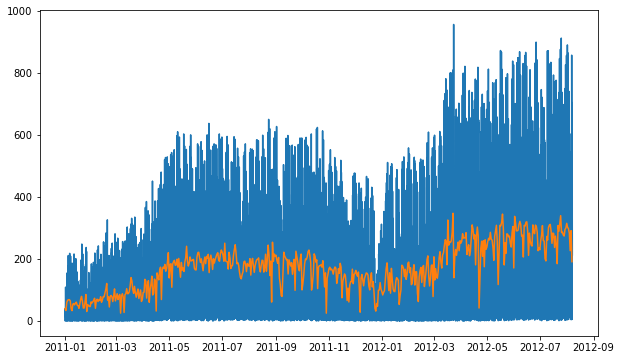

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['cnt'])
plt.plot(new_train_data['cnt'])
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_15884\1885049706.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.value = df.cnt


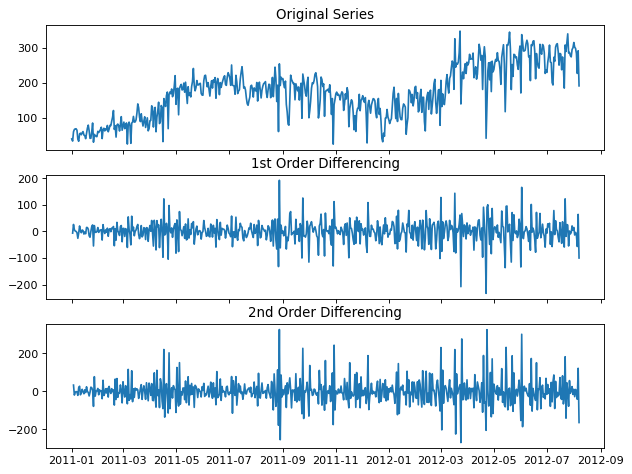

In [33]:
# Now since the graph is not stationary, turn it to stationary

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi': 80})
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

df = new_train_data
df.value = df.cnt

# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(df.value); 
axes[0].set_title('Original Series')
# plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1].plot(df.value.diff())
axes[1].set_title('1st Order Differencing')
# plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

axes[2].plot(df.value.diff().diff())
axes[2].set_title('2nd Order Differencing')

plt.show()

# On 2nd order differencing we are loosing more information so considering 1st order differencing
# d can be taken as 2

In [34]:
# To test if the differenced time series is stationary
from statsmodels.tsa.stattools import adfuller
test = new_train_data.copy()
count = 2

for i in range(count):
    test.cnt = test.cnt.diff() # Differencing 1 time
    test['cnt'].fillna(test['cnt'][1], inplace=True)

result = adfuller(test['cnt'])
result

# Since p-value < 0.05, it is stationary

(-11.097275170889928,
 3.9449982413752225e-20,
 19,
 565,
 {'1%': -3.4419770063102213,
  '5%': -2.866669060591297,
  '10%': -2.5695016312945413},
 5732.150899420615)

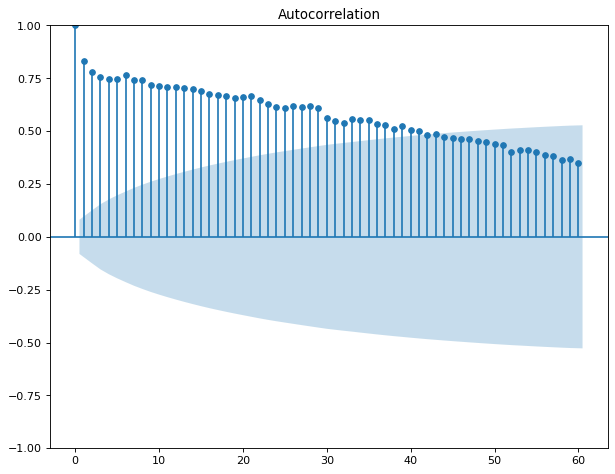

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(new_train_data['cnt'], lags = 60)
plt.show()

# p value can be taken as 7

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


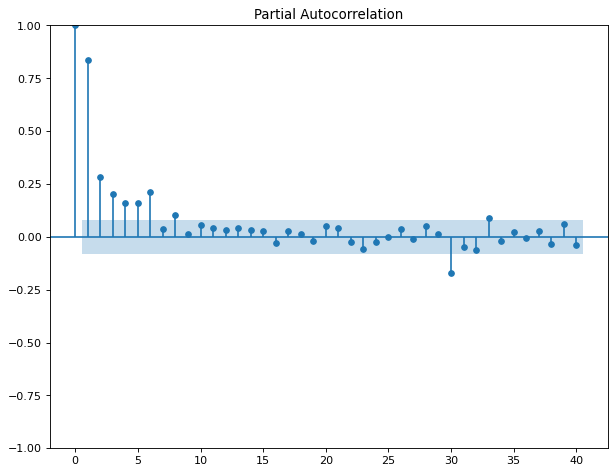

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(new_train_data['cnt'], lags = 40)
plt.show()

# p value can be taken as 5

In [37]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df.value, order=(10,3,8))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  585
Model:                ARIMA(10, 3, 8)   Log Likelihood               -2919.406
Date:                Fri, 14 Apr 2023   AIC                           5876.813
Time:                        19:35:20   BIC                           5959.776
Sample:                    01-01-2011   HQIC                          5909.153
                         - 08-07-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.3695      0.102    -32.904      0.000      -3.570      -3.169
ar.L2         -5.3405      0.360    -14.831      0.000      -6.046      -4.635
ar.L3         -4.7764      0.642     -7.436      0.0

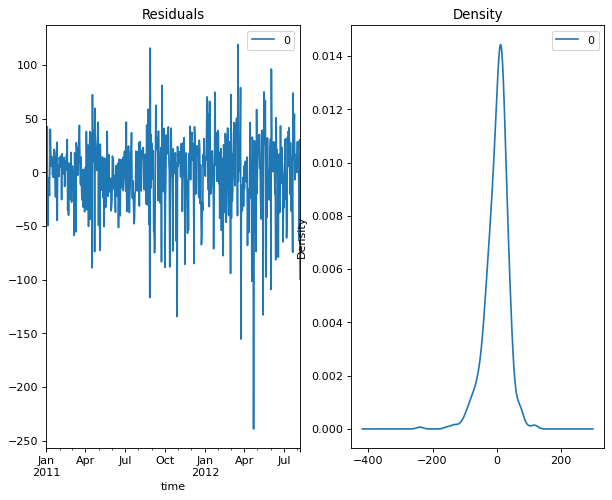

In [38]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

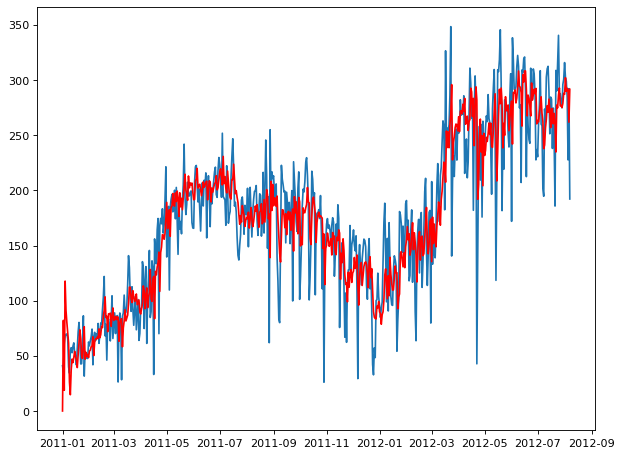

In [39]:
plt.plot(new_train_data['cnt'])
plt.plot(model_fit.fittedvalues, color='red')

In [40]:
mse = mean_squared_error(new_train_data['cnt'], model_fit.fittedvalues)
rmsle = np.sqrt(mean_squared_log_error(new_train_data['cnt'], model_fit.fittedvalues))
mae = mean_absolute_error(new_train_data['cnt'], model_fit.fittedvalues)

print("MSE: ", mse)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

MSE:  1275.0482898838488
RMSLE:  0.32114541094354426
MAE:  26.004632453848536


In [41]:
steps = len(new_test_data.index)

In [42]:
start = len(new_train_data)
end = len(new_train_data) + len(new_test_data) - 1
result = model_fit.predict(start=start, end=end, type='levels')
result

2012-08-08    251.152168
2012-08-09    268.529202
2012-08-10    273.857123
2012-08-11    274.469592
2012-08-12    275.842716
                 ...    
2012-12-28     92.968463
2012-12-29     90.181379
2012-12-30     89.872902
2012-12-31     87.425840
2013-01-01     83.023313
Freq: D, Name: predicted_mean, Length: 147, dtype: float64

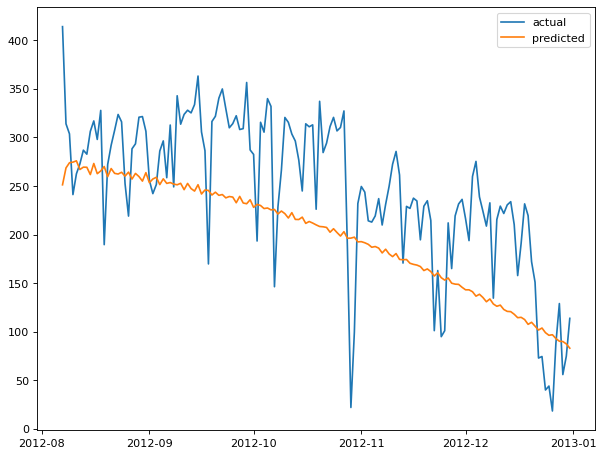

In [43]:


# fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

test = new_test_data[:steps]

plt.plot(test.index, test['cnt'], label='actual')
plt.plot(test.index, result, label='predicted')
plt.legend()
plt.show()
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(new_train_data, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [44]:
print("For Test Data: ")

testing = new_test_data['cnt']

mse = mean_squared_error(testing[:steps], result)
rmsle = np.sqrt(mean_squared_log_error(testing[:steps], result))
mae = mean_absolute_error(testing[:steps], result)

print("MSE: ", mse)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

For Test Data: 
MSE:  5322.7154474794015
RMSLE:  0.41116898925491474
MAE:  63.70140148685284


# PMDARIMA

In [45]:
train = data.copy()

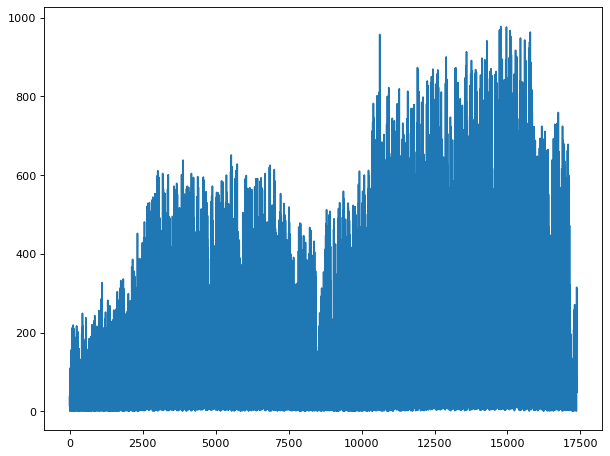

In [46]:
plt.plot(train['cnt'])

In [47]:
train.set_index('time', inplace=True)
train.index = pd.to_datetime(train.index)

In [48]:
print("Length before resampling: " + str(len(train)))
train = train.resample('D').median()
print("Length after resampling: " + str(len(train)))

Length before resampling: 17379
Length after resampling: 731


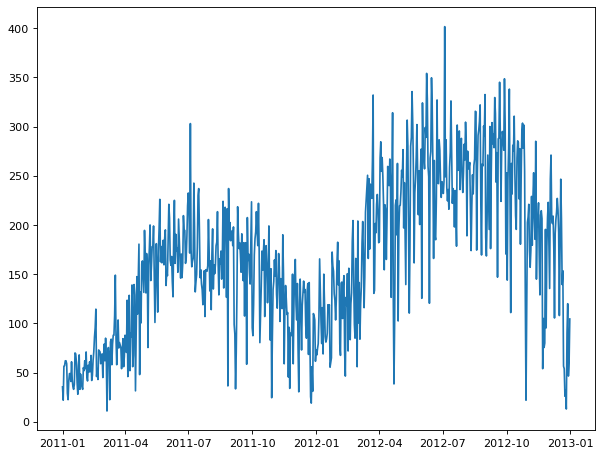

In [49]:
plt.plot(train['cnt'])

In [50]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    result = adfuller(dataset, autolag = 'AIC')
    print('1. ADF: ', result[0])
    print('2. P-Value: ', result[1])
    print('3. Num of lags: ', result[2])
    print('4. Num of observations for ADF regression and critical values calculation: ', result[3])
    print('5. Critical values: ')
    for key, val in result[4].items():
        print('\t', key,":",val)

In [51]:
total = len(train)

split = int(total * 0.75)

new_train = train[:split]
new_test = train[split:]

In [52]:
adf_test(new_train['cnt'])

1. ADF:  -1.3388693688093107
2. P-Value:  0.6112073403795406
3. Num of lags:  13
4. Num of observations for ADF regression and critical values calculation:  534
5. Critical values: 
	 1% : -3.4426552678216003
	 5% : -2.8669676577777548
	 10% : -2.569660749624767


In [53]:
from pmdarima import auto_arima

In [54]:
model = auto_arima(new_train['cnt'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5619.456, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5833.889, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5769.729, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5644.580, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5831.919, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5622.007, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5621.051, Time=0.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5624.273, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5618.883, Time=2.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5621.256, Time=1.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5600.896, Time=2.78 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5618.559, Time=2.45 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=5615.442, Time=2.78 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=5617.346, Time=3.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  548
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2792.788
Date:                Fri, 14 Apr 2023   AIC                           5599.576
Time:                        19:36:10   BIC                           5629.707
Sample:                    01-01-2011   HQIC                          5611.354
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4526      0.048     30.264      0.000       1.359       1.547
ar.L2         -1.2248      0.056    -21.760      0.000      -1.335      -1.114
ar.L3          0.1836      0.042      4.375      0.000       0.101       0.266
ma.L1         -2.1533      0.039    -55.685      0.000      -2.229      -2.078
ma.L2          2.0851      0.061     34.446      0.000       1.966       2.204
ma.L3         -0.8503      0.036    -23.806      0.000      -0.920      -0.780
sigma2      1560.4898     74.707     20.888      0.000    1414.067    1706.913
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
model = ARIMA(new_train['cnt'],order=(3,1,3))
model = model.fit()
model.summary()

c:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    cnt   No. Observations:                  548
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2792.788
Date:                Fri, 14 Apr 2023   AIC                           5599.576
Time:                        19:36:12   BIC                           5629.707
Sample:                    01-01-2011   HQIC                          5611.354
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4526      0.048     30.264      0.000       1.359       1.547
ar.L2         -1.2248      0.056    -21.760      0.000      -1.335      -1.114
ar.L3          0.1836      0.042      4.375      0.000       0.101       0.266
ma.L1         -2.1533      0.039    -55.685      0.000      -2.229      -2.078
ma.L2          2.0851      0.061     34.446      0.000       1.966       2.204
ma.L3         -0.8503      0.036    -23.806      0.000      -0.920      -0.780
sigma2      1560.4898     74.707     20.888      0.000    1414.067    1706.913
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.89
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

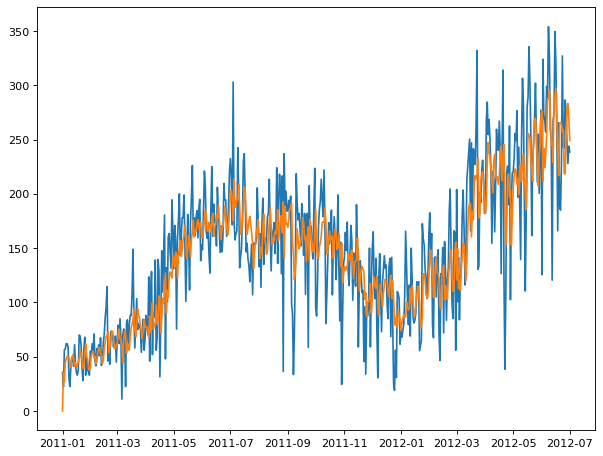

In [57]:
# new_train.plot()
# model.fittedvalues().plot()
plt.plot(new_train['cnt'])
plt.plot(model.fittedvalues)


In [58]:
print("For Train Data: ")

testing = new_train['cnt']
result = model.fittedvalues

mse = mean_squared_error(testing, result)
rmsle = np.sqrt(mean_squared_log_error(testing, result))
mae = mean_absolute_error(testing, result)

print("MSE: ", mse)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

For Train Data: 
MSE:  1585.9364363854447
RMSLE:  0.37461150126619036
MAE:  29.99587618201452


In [59]:
start = len(new_train)
# start = 0
end = len(new_train) + len(new_test) - 1
# end= len(new_test)
pred = model.predict(start=start, end = end, type='levels')

pred

2012-07-02    225.993801
2012-07-03    216.414236
2012-07-04    225.817216
2012-07-05    248.913186
2012-07-06    269.187507
                 ...    
2012-12-27    242.508066
2012-12-28    235.036761
2012-12-29    235.155545
2012-12-30    242.700988
2012-12-31    252.144615
Freq: D, Name: predicted_mean, Length: 183, dtype: float64

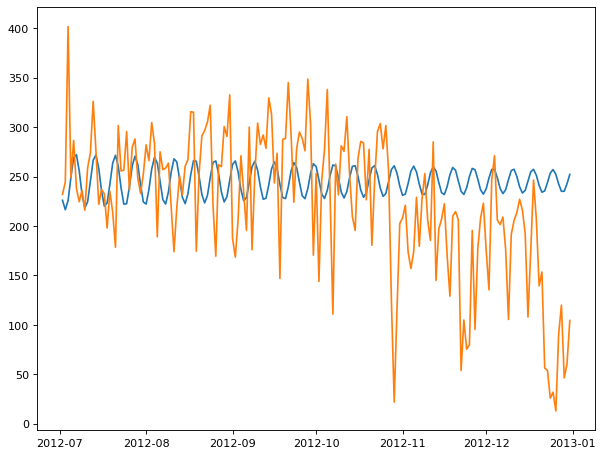

In [60]:
# pred.plot(legend=True)
# new_test['cnt'].plot(legend=True)
plt.plot(pred)
plt.plot(new_test['cnt'])

In [61]:
# from the above graph we can say that ARIMA was able to capture the trend approximately.
# Due to lower amount of train data it is not able to predict precisely

print("For Test Data: ")

testing = new_test['cnt']
result = pred

mse = mean_squared_error(testing, result)
rmsle = np.sqrt(mean_squared_log_error(testing, result))
mae = mean_absolute_error(testing, result)

print("MSE: ", mse)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

For Test Data: 
MSE:  6157.350510448444
RMSLE:  0.5381120364146091
MAE:  59.53726204527039


In [62]:
# Checking if the data is seasonal
from statsmodels.tsa.seasonal import seasonal_decompose

copy = data.copy()

copy.set_index('time', inplace=True)
copy.index = pd.to_datetime(copy.index)

copy = copy.resample('D').mean()

In [63]:
copy['cnt']

time
2011-01-01     41.041667
2011-01-02     34.826087
2011-01-03     61.318182
2011-01-04     67.913043
2011-01-05     69.565217
                 ...    
2012-12-27     88.083333
2012-12-28    128.958333
2012-12-29     55.875000
2012-12-30     74.833333
2012-12-31    113.708333
Freq: D, Name: cnt, Length: 731, dtype: float64

In [64]:
# copy = copy[['cnt']]

# SARIMA

In [65]:
from pmdarima.arima import auto_arima

# Split data into training and testing sets

copy = data.copy()


copy.set_index('time', inplace=True)
copy.index = pd.to_datetime(copy.index)

copy = copy.resample('D').median()

split = int(len(copy) * 0.75)
train = copy[:split]
test = copy[split:]

print('Train Length: ', len(train))
print("Test Length: ", len(test))

Train Length:  548
Test Length:  183


In [66]:
# Fit the best SARIMA model using auto_arima
model = auto_arima(train['cnt'], seasonal=True, m=12, stepwise=True, suppress_warnings=True, start_p=1, start_q=1, test='adf', max_p=20, max_q=20)

# Generate forecasts for the test set
forecast = model.predict(n_periods=len(test))

# Print the model summary
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  548
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood               -2799.857
Date:                             Fri, 14 Apr 2023   AIC                           5617.714
Time:                                     19:38:25   BIC                           5656.454
Sample:                                 01-01-2011   HQIC                          5632.857
                                      - 07-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5168      0.344      1.501      0.133      -0.158       1.192
ar.L1          0.1481      

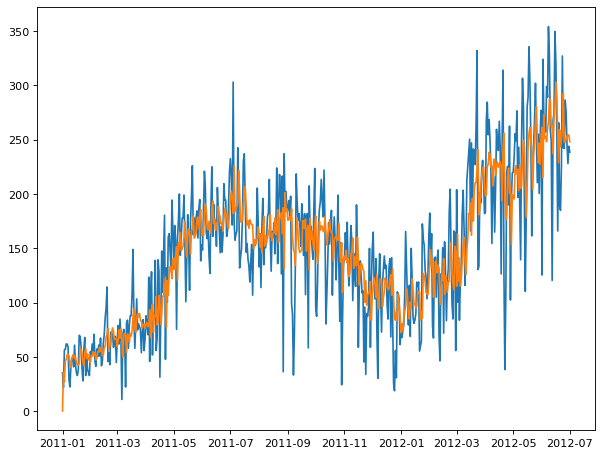

In [67]:
plt.plot(train.index, train['cnt'])
plt.plot(train.index, model.fittedvalues())

In [68]:
forecast

2012-07-02    258.708741
2012-07-03    265.172438
2012-07-04    261.997467
2012-07-05    250.914828
2012-07-06    256.245197
                 ...    
2012-12-27    321.991285
2012-12-28    322.374775
2012-12-29    322.758264
2012-12-30    323.141754
2012-12-31    323.525243
Freq: D, Length: 183, dtype: float64

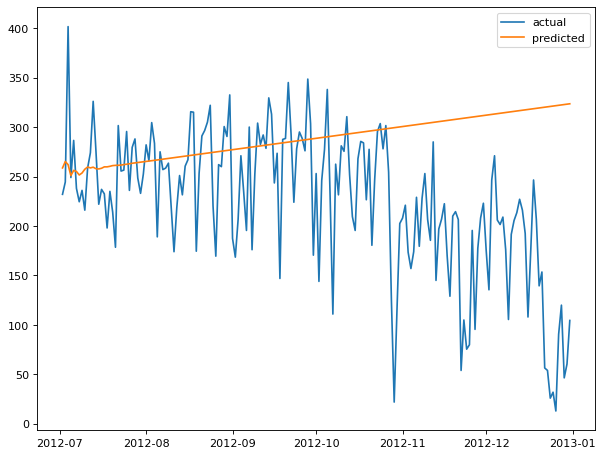

In [69]:
plt.plot(test.index, test.cnt, label='actual')
plt.plot(test.index, forecast, label='predicted')
plt.legend()
plt.show()

In [70]:
print("For Test Data: ")

testing = test['cnt']
result = forecast

mse = mean_squared_error(testing, result)
rmsle = np.sqrt(mean_squared_log_error(testing, result))
mae = mean_absolute_error(testing, result)

print("MSE: ", mse)
print("RMSLE: ", rmsle)
print("MAE: ", mae)

For Test Data: 
MSE:  11452.462736559753
RMSLE:  0.6345432084110224
MAE:  77.6881975491403


# LSTM

In [684]:
df = data.copy()
df.tail()

WINDOW_SIZE=24

In [685]:
df.index = pd.to_datetime(df['time'])

In [686]:
def matrix_and_vector_generator(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    Y = []
    for i in range(len(df_as_np) - window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        Y.append(df_as_np[i+window_size])
    return np.array(X), np.array(Y)

In [687]:
def replace_outliers_quantile(data, q_low=0.05, q_high=0.95):
    q1 = data.quantile(q_low)
    q3 = data.quantile(q_high)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data_clipped = data.clip(lower_bound, upper_bound)
    num_outliers = (data < lower_bound) | (data > upper_bound).sum()
    return data_clipped, num_outliers

# Apply the outlier replacement function
# data_cleaned, num_outliers = replace_outliers_quantile(data)

# Print the number of outliers and the cleaned data
# print(f"Number of outliers: {num_outliers}")
# print(f"Cleaned data: {data_cleaned}")

In [688]:
# Split the data into three 0.8, 0.1, 0.1 for training, validation and testing

col = df['cnt']

total_length = len(col)

train_ratio, validation_ratio = 0.8, 0.1

train_length = int(train_ratio * total_length)
validation_length = int(validation_ratio * total_length)
test_length = total_length - ( train_length + validation_length )

train_data = col[:train_length]
validation_data = col[train_length:train_length + validation_length]
test_data = col[train_length + validation_length : ]

upper_bound, lower_bound = 1, 0

train_data, _ = replace_outliers_quantile(train_data, lower_bound, upper_bound)
validation_data, _ = replace_outliers_quantile(validation_data, lower_bound, upper_bound)

In [689]:
x_train,y_train = matrix_and_vector_generator(train_data, WINDOW_SIZE)
x_validation, y_validation = matrix_and_vector_generator(validation_data, WINDOW_SIZE)
x_test, y_test = matrix_and_vector_generator(test_data, WINDOW_SIZE)

print("Train Shape: ", str(x_train.shape),' - ', str(y_train.shape))
print("Validation Shape: ", str(x_validation.shape),' - ', str(y_validation.shape))
print("Test Shape: ", str(x_test.shape),' - ', str(y_test.shape))

Train Shape:  (13879, 24)  -  (13879,)
Validation Shape:  (1713, 24)  -  (1713,)
Test Shape:  (1715, 24)  -  (1715,)


In [690]:
# length = x.shape[0]

# test_length = int(length * 0.8)
# val_length = int(length * 0.1)

# x_train, y_train = x[:test_length], y[:test_length]
# x_val, y_val  = x[test_length:test_length + val_length], y[test_length:test_length + val_length]
# x_test, y_test = x[test_length + val_length:], y[test_length + val_length:]

In [691]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError as Mae
from keras.optimizers import Adam

In [693]:
model1 = Sequential()

model1.add(InputLayer((WINDOW_SIZE, 1)))

model1.add(LSTM(64))

model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))

model1.add(Dense(1))

model1.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 64)                16896     
                                                                 
 dense_120 (Dense)           (None, 32)                2080      
                                                                 
 dense_121 (Dense)           (None, 32)                1056      
                                                                 
 dense_122 (Dense)           (None, 32)                1056      
                                                                 
 dense_123 (Dense)           (None, 1)                 33        
                                                                 
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________


In [694]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0001), metrics=[Mae()])

In [695]:
model1.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=10, callbacks=[cp])

Epoch 1/10
433/434 [============================>.] - ETA: 0s - loss: 166.4882 - mean_absolute_error: 166.4882

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 25s 52ms/step - loss: 166.4625 - mean_absolute_error: 166.4625 - val_loss: 262.4252 - val_mean_absolute_error: 262.4252
Epoch 2/10
433/434 [============================>.] - ETA: 0s - loss: 100.7052 - mean_absolute_error: 100.7052

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 15s 35ms/step - loss: 100.6522 - mean_absolute_error: 100.6522 - val_loss: 135.3614 - val_mean_absolute_error: 135.3614
Epoch 3/10
430/434 [============================>.] - ETA: 0s - loss: 50.6900 - mean_absolute_error: 50.6900

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 7s 16ms/step - loss: 50.6059 - mean_absolute_error: 50.6059 - val_loss: 87.7162 - val_mean_absolute_error: 87.7162
Epoch 4/10
428/434 [============================>.] - ETA: 0s - loss: 41.1656 - mean_absolute_error: 41.1656

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 8s 17ms/step - loss: 41.2174 - mean_absolute_error: 41.2174 - val_loss: 72.4712 - val_mean_absolute_error: 72.4712
Epoch 5/10
430/434 [============================>.] - ETA: 0s - loss: 38.1087 - mean_absolute_error: 38.1087

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 9s 22ms/step - loss: 38.1590 - mean_absolute_error: 38.1590 - val_loss: 66.0437 - val_mean_absolute_error: 66.0437
Epoch 6/10
433/434 [============================>.] - ETA: 0s - loss: 36.2315 - mean_absolute_error: 36.2315

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 22s 50ms/step - loss: 36.2486 - mean_absolute_error: 36.2486 - val_loss: 63.2408 - val_mean_absolute_error: 63.2408
Epoch 7/10
429/434 [============================>.] - ETA: 0s - loss: 35.1593 - mean_absolute_error: 35.1593

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 11s 25ms/step - loss: 35.1008 - mean_absolute_error: 35.1008 - val_loss: 61.6609 - val_mean_absolute_error: 61.6609
Epoch 8/10
433/434 [============================>.] - ETA: 0s - loss: 34.3991 - mean_absolute_error: 34.3991

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 22s 52ms/step - loss: 34.4038 - mean_absolute_error: 34.4038 - val_loss: 59.8011 - val_mean_absolute_error: 59.8011
Epoch 9/10
433/434 [============================>.] - ETA: 0s - loss: 33.4575 - mean_absolute_error: 33.4575

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


434/434 [==============================] - 13s 30ms/step - loss: 33.4589 - mean_absolute_error: 33.4589 - val_loss: 56.4551 - val_mean_absolute_error: 56.4551
Epoch 10/10
434/434 [==============================] - 4s 9ms/step - loss: 32.4394 - mean_absolute_error: 32.4394 - val_loss: 57.7010 - val_mean_absolute_error: 57.7010


In [696]:
from keras.models import load_model

model1 = load_model('model1/')

In [697]:
train_predictions = model1.predict(x_train).flatten()

434/434 [==============================] - 2s 4ms/step


In [698]:
train_predictions.shape, y_train.shape

((13879,), (13879,))

In [699]:
train_results = pd.DataFrame(data={'Train predictions': train_predictions, 'Actuals' : y_train} )

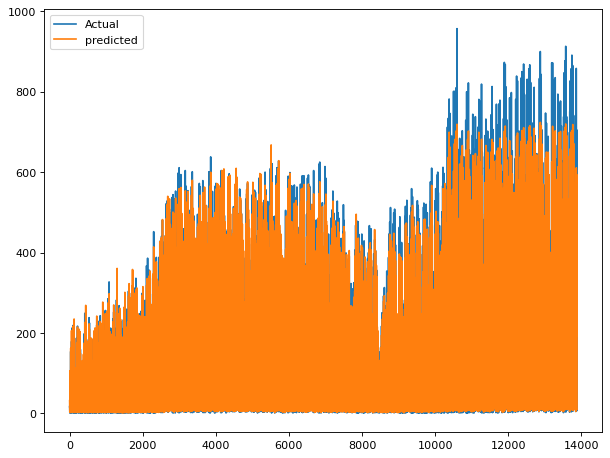

In [700]:
size = None

predictions = None
actuals = None

if size != None:
    predictions = train_results['Train predictions'][:size]
    actuals = train_results['Actuals'][:size]
else:
    predictions = train_results['Train predictions'][:]
    actuals = train_results['Actuals'][:]

plt.plot(actuals, label='Actual')
plt.plot(predictions, label='predicted')
plt.legend()

In [701]:
from sklearn.metrics import mean_squared_error, median_absolute_error

actuals = train_results['Actuals']
predicted = train_results['Train predictions']

print("For Train data:")

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

mdae = median_absolute_error(actuals, predicted)
print("MDAE: ", mdae)

For Train data:
MAE:  32.45503330319181
RMSE: 54.90986650898968
MDAE:  16.632095336914062


In [702]:
test_predictions = model1.predict(x_test).flatten()

54/54 [==============================] - 0s 4ms/step


In [703]:
test_predictions.shape, y_test.shape

((1715,), (1715,))

In [704]:
test_results = pd.DataFrame(data={'Test predictions': test_predictions, 'Actuals' : y_test} )

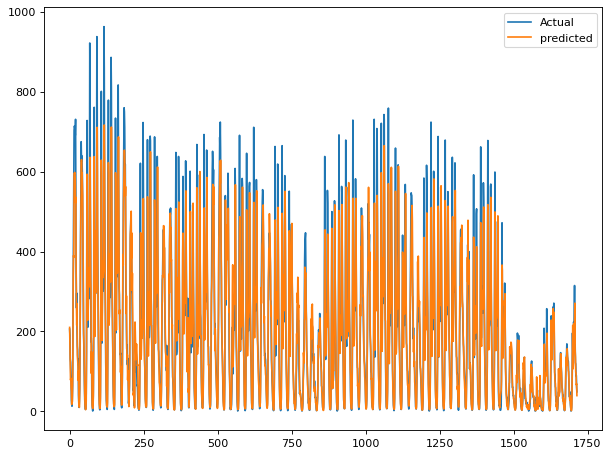

In [708]:
size = None

predictions = None
actuals = None

x = test_results

if size != None:
    predictions = x['Test predictions'][:size]
    actuals = x['Actuals'][:size]
else:
    predictions = x['Test predictions'][:]
    actuals = x['Actuals'][:]

plt.plot(actuals, label='Actual')
plt.plot(predictions, label='predicted')
plt.legend()

In [706]:
actuals = test_results['Actuals']
predicted = test_results['Test predictions']

mae = mean_absolute_error(actuals, predicted)
print("MAE: ", str(mae))

# calculate MSE
rmse = np.sqrt(mean_squared_error(actuals, predicted))
print('RMSE:', rmse)

mdae = median_absolute_error(actuals, predicted)
print("MDAE: ", mdae)

MAE:  38.62204741903366
RMSE: 63.921728479206834
MDAE:  19.373348236083984


# LSTM with other parameters